In [ ]:
import pandas as pd
import numpy as np

def view_tests(initializations, algorithms, file_path, style=True):
    """
    Perform tests on the initialization and algorithm methods.
    
    Parameters
    ----------
    initializations : list
        List of initialization methods
    algorithms : list
        List of algorithm methods
    file_path : str
        Path of the file to load
    
    Returns
    -------
    pd.DataFrame
        Table with algorithms as columns, each column divided for initializations and rows as: algorithms, centroid index, time execution
    """

    data_frames = {}

    # read table from path
    name = ''.join(file_path.split('/')[1:]).split('.')[0]


    for algorithm in algorithms:
        test_data = pd.read_csv(f'tests/{name}-{algorithm}.csv', sep=',', engine='python')

        test_data = test_data[test_data["initialization"].isin(initializations)]
        data_frames[algorithm] = test_data.groupby("initialization", sort=False).agg(lambda x: list(x))

        # compute means/maxs/mins and count
        data_frames[algorithm]['count'] = data_frames[algorithm]['TIME_EXECUTION'].apply(lambda x: len(x))
        
        if not data_frames[algorithm]['CENTROID_INDEX'].isna().any():
            data_frames[algorithm]['min_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.min(x))
            data_frames[algorithm]['max_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.max(x))
            data_frames[algorithm]['mean_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.mean(x))
            data_frames[algorithm]['std_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.std(x))
        
        data_frames[algorithm]['mean_time_execution'] = data_frames[algorithm]['TIME_EXECUTION'].apply(lambda x: np.mean(x))
        
        data_frames[algorithm]['min_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.min(x))
        data_frames[algorithm]['mean_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['max_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.max(x))
        data_frames[algorithm]['std_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.std(x))
        
        data_frames[algorithm]['mean_safe_iterations'] = data_frames[algorithm]['SAFE_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_unsafe_iterations'] = data_frames[algorithm]['UNSAFE_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_lloyd_iterations'] = data_frames[algorithm]['LLYOID_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_hartigan_iterations'] = data_frames[algorithm]['HARTIGAN_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_binary_iterations'] = data_frames[algorithm]['BINARY_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_tot_iterations'] = data_frames[algorithm]['SAFE_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['UNSAFE_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['LLYOID_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['HARTIGAN_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['BINARY_ITERATIONS'].apply(lambda x: np.mean(x))
        
        data_frames[algorithm]['mean_init_norm_calculations'] = data_frames[algorithm]['INIT_NORM_CALCULATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_norm_calculations'] = data_frames[algorithm]['NORM_CALCULATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_tot_norm_calculations'] = data_frames[algorithm]['INIT_NORM_CALCULATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['NORM_CALCULATIONS'].apply(lambda x: np.mean(x))

        # drop columns
        data_frames[algorithm].drop(columns=['CENTROID_INDEX', 'TIME_EXECUTION', 'FINAL_COST', 'SAFE_ITERATIONS', 'UNSAFE_ITERATIONS', 'LLYOID_ITERATIONS', 'HARTIGAN_ITERATIONS', 'BINARY_ITERATIONS', 'INIT_NORM_CALCULATIONS', 'NORM_CALCULATIONS'], inplace=True)

    result_df = pd.concat(data_frames, axis=0, keys=algorithms, names=["Algorithm", "Initialization"])
    
    def color_specific_columns(x):
        df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
        df_styled.loc[:, ['min_final_cost', 'mean_tot_iterations', 'mean_tot_norm_calculations', 'mean_centroid_index']] = 'font-weight: bold'
        return df_styled

    def add_vertical_lines(x):
        df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
        # Add borders after columns B and C
        df_styled.loc[:, ['count', 'min_centroid_index', 'mean_time_execution', 'min_final_cost', 'mean_safe_iterations', 'mean_init_norm_calculations']] = 'border-left: 1px solid gray'
        return df_styled

    if style:
        # Apply the styles to the DataFrame
        result_df = result_df.style.apply(color_specific_columns, axis=None).apply(add_vertical_lines, axis=None)

    return result_df

def min_found(initializations, algorithms, file_path, treshold):
    """
    Returns the percentage of times a minimum (under a certain treshold) was found for each initialization and algorithm.


    Parameters
    ----------
    initializations : list
        List of initialization methods
    algorithms : list
        List of algorithm methods
    file_path : str
        Path of the file to load
    treshold : float
        Treshold for the minimum


    Returns
    -------
    pd.DataFrame
        Table with algorithms as columns, each column divided for initializations and rows as: algorithms, centroid index, time execution
    """
    # read table from path
    name = ''.join(file_path.split('/')[1:]).split('.')[0]

    dict_data = {}
    for algorithm in algorithms:
        data = pd.read_csv(f'tests/{name}-{algorithm}.csv', sep=',', engine='python')
        data = data[data["initialization"].isin(initializations)]
        data = data.groupby("initialization", sort=False).agg(lambda x: list(x))
        dict_data[algorithm] = data

    result_df = pd.DataFrame(columns=initializations, index=algorithms)

    for algorithm, data in dict_data.items():
        for initialization in initializations:
            # calculate the percentage of times a minimum was found
            min_found = np.sum(np.array(data['FINAL_COST'][initialization]) <= treshold) / len(data['FINAL_COST'][initialization])
            result_df.loc[algorithm, initialization] = min_found
    
    # all entries must have 3 numbers after the comma
    result_df = result_df.map(lambda x: f'{x:.3f}')
    
    return result_df

In [31]:
view_tests(['random', 'maximin', 'k-means++', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a3.txt')

In [32]:
def get_CI(algorithms, initializations, file_path):
        
    data_frames = {}

    # read table from path
    name = ''.join(file_path.split('/')[1:]).split('.')[0]


    for algorithm in algorithms:
        test_data = pd.read_csv(f'tests/{name}-{algorithm}.csv', sep=',', engine='python')

        test_data = test_data[test_data["initialization"].isin(initializations)]
        data_frames[algorithm] = test_data.groupby("initialization", sort=False).agg(lambda x: list(x))

    
    result_df = pd.concat(data_frames, axis=0, keys=algorithms, names=["Algorithm", "Initialization"])

    return result_df['CENTROID_INDEX']

CI = get_CI(['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], ['random', 'maximin', 'k-means++', 'greedy-k-means++'], 'data/A-Sets/a3.txt')

In [33]:
CI

Algorithm                Initialization  
lloyd                    maximin             [4, 1, 6, 2, 3, 6, 2, 3, 6, 3, 3, 2, 2, 3, 5, ...
                         k-means++           [5, 3, 5, 3, 5, 4, 3, 5, 5, 5, 4, 3, 2, 4, 3, ...
                         greedy-k-means++    [3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 3, 2, 1, ...
hartigan                 maximin             [3, 3, 5, 4, 3, 5, 2, 4, 2, 2, 3, 1, 2, 1, 4, ...
                         k-means++           [5, 5, 4, 3, 4, 6, 4, 5, 3, 4, 3, 3, 3, 5, 3, ...
                         greedy-k-means++    [0, 1, 2, 2, 0, 2, 2, 2, 1, 0, 3, 1, 2, 1, 2, ...
extended-hartigan        maximin             [3, 3, 2, 2, 2, 1, 3, 5, 3, 3, 5, 3, 2, 1, 3, ...
                         k-means++           [3, 4, 3, 1, 4, 5, 3, 3, 4, 5, 3, 4, 6, 6, 4, ...
                         greedy-k-means++    [1, 3, 2, 1, 2, 2, 1, 3, 1, 2, 2, 1, 1, 2, 2, ...
mixed-hartigan           maximin             [1, 3, 3, 2, 2, 3, 4, 3, 5, 1, 3, 3, 3, 3, 3, ...
        

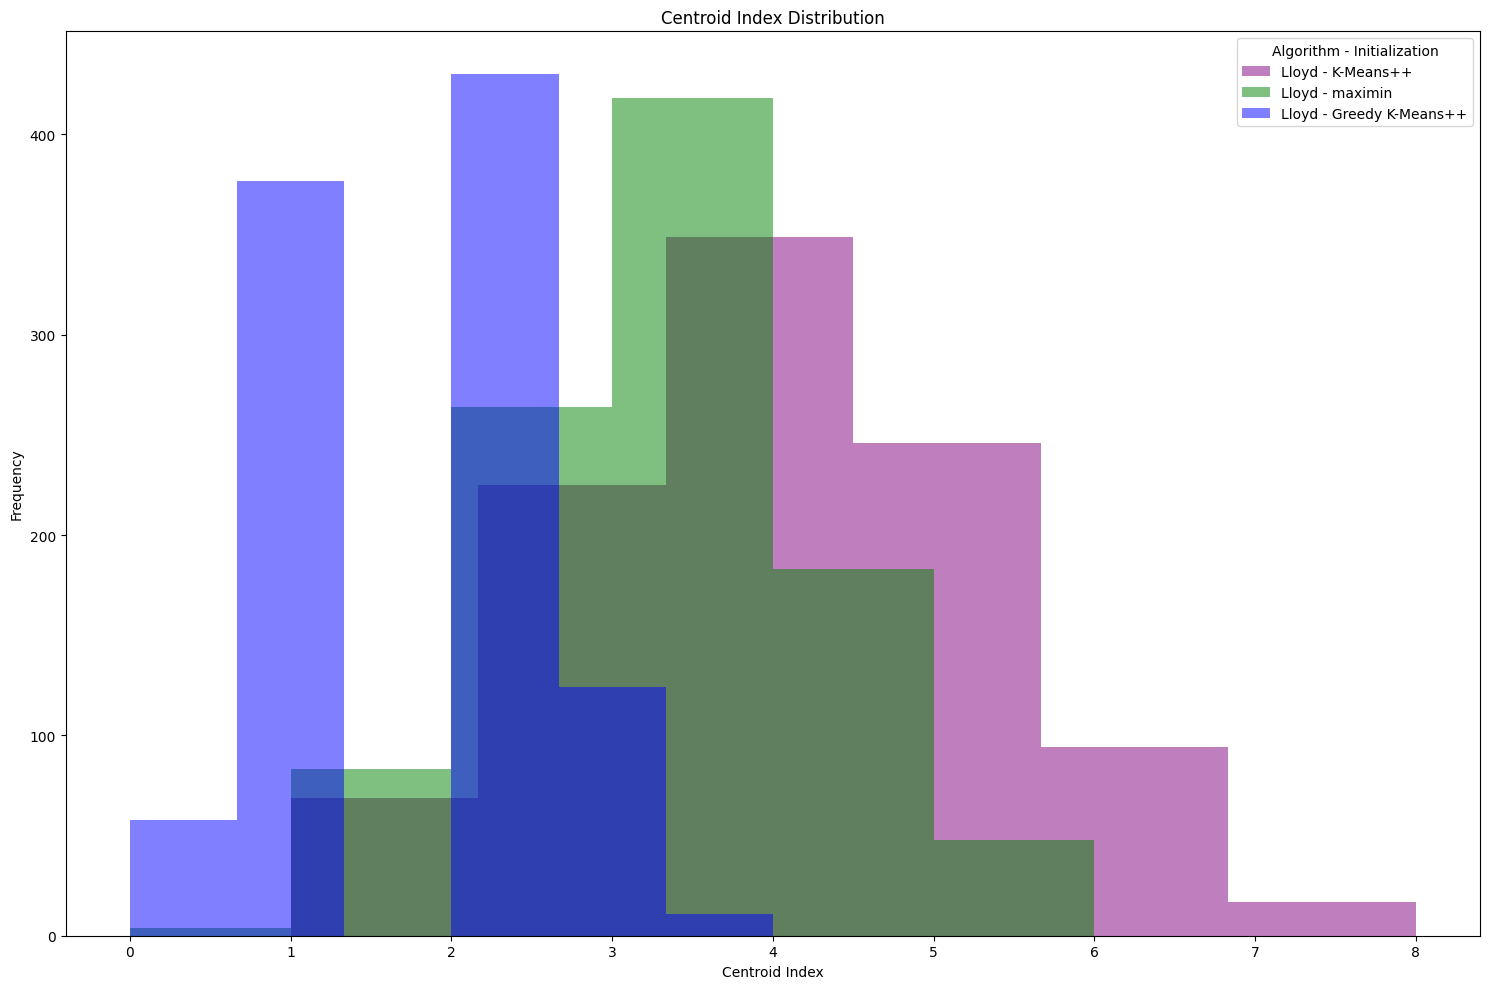

In [66]:
# plot distribution of centroid index
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Define colors for each algorithm
colors = ['blue', 'green', 'red', 'purple', 'orange']

# make bins ticker
plt.hist(CI['lloyd', 'k-means++'], bins=6, alpha=0.5, label='Lloyd - K-Means++', color=colors[3])
plt.hist(CI['lloyd', 'maximin'], bins=6, alpha=0.5, label='Lloyd - maximin', color=colors[1])
plt.hist(CI['lloyd', 'greedy-k-means++'], bins=6, alpha=0.5, label='Lloyd - Greedy K-Means++', color=colors[0])

plt.title('Centroid Index Distribution')
plt.xlabel('Centroid Index')
plt.ylabel('Frequency')
plt.legend(title='Algorithm - Initialization')
plt.tight_layout()
plt.show()

In [58]:
CI['lloyd', 'greedy-k-means++']
# count values
pd.Series(CI['lloyd', 'greedy-k-means++']).value_counts().sort_index()

0     58
1    377
2    430
3    124
4     11
Name: count, dtype: int64